<a href="https://colab.research.google.com/github/yusufdimari/deep_learning/blob/main/Alexnet_Resnet_Autoencoder_on_google_fonts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
imdb = torch.load('/content/charsdbb.pth')
print(f"imdb['images'] has shape: {imdb['images'].shape}")
print(f"imdb['labels'] has shape: {imdb['labels'].shape}")
print(f"imdb['sets] has shape: {imdb['sets'].shape}")

imdb['images'] has shape: torch.Size([29094, 1, 32, 32])
imdb['labels'] has shape: torch.Size([29094])
imdb['sets] has shape: torch.Size([29094])


<ipython-input-2-f1aab4be619d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  imdb = torch.load('/content/charsdbb.pth')


torch.Size([770, 1, 32, 32])


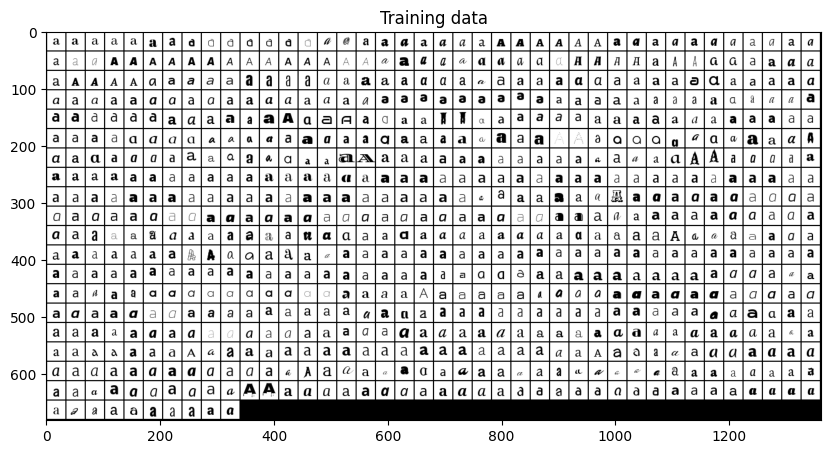

In [ ]:
import torchvision
# Plot the training data for 'a'
plt. figure(1,figsize=(10,10))
plt.clf()
plt. title('Training data')
sel=(imdb['sets']==0) & (imdb['labels']==0)
images_sel=(imdb[ 'images'] [sel,:,:, :])
print(images_sel.size())

tensor_grid=torchvision.utils.make_grid(images_sel,nrow=40)
image_grid=tensor_grid.permute(1,2,0)
plt.imshow(image_grid)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class Char_Dataset(Dataset):
    def __init__(self,data,target,train:bool = True, transforms=None):
        self.data=data
        self.target=target
        self.train=train
        self.transforms=transforms

    def __getitem__(self,index):

        x=self.data[index,]

        if(self.train):
            if(self.transforms):
                x=self.transforms(x)


        if(self.train):
            # During training, for each image the Dataset returns
            #  - an image x
            #  - the true class y:
            y=self.target[index,]
            return x,y
        else:
            # During testing, only the image is returned
            return x

    def __len__(self):
        return len(self.target)

In [ ]:
def InitializeDataLoaders(Xtrain, Ytrain, Xvalid, Yvalid, batch_size=500):
    # Initializion datasets and dataloaders
    #batch_size = 500

    train_dataset=Char_Dataset(
        data=Xtrain,
        target=Ytrain,
        train=True,
        transforms=None
    )

    valid_dataset=Char_Dataset(
        data=Xvalid,
        target=Yvalid,
        train=True,
        transforms=None
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        #num_workers=4,
        shuffle=True,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        #num_workers=4,
        shuffle=True,
    )

    datasets={'train':train_dataset,'valid':valid_dataset}
    dataloaders={'train':train_loader,'valid':valid_loader}

    return datasets, dataloaders

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting data into training and validation
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(
imdb['images'], imdb['labels'],
test_size=0.2, random_state=42,)
datasets, dataloaders = InitializeDataLoaders(Xtrain, Ytrain, Xvalid, Yvalid)

In [ ]:
def cnn_training(model, datasets, dataloaders, criterion, optimizer, device, num_epochs):

    for epoch in range(num_epochs):

        running_loss = 0.0
        running_corrects = 0.0

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels=labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Statistics
                    running_loss += loss.item()*inputs.size(0)
                    running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects.double()/len(datasets[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model

In [ ]:
class Simple_CNN(nn.Module):
    def __init__(self, num_classes=26):
        super(Simple_CNN, self).__init__()

        # Smaller kernel and stride values for small images
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input: 1x32x32 -> 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32x32x64

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples by a factor of 2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 16x16x128
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 8x8x256

        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Flattened from 8x8x256
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))  # Conv1 -> Pool (16x16)
        x = self.maxpool(F.relu(self.conv2(x)))  # Conv2 -> Pool (8x8)
        x = F.relu(self.conv3(x))                # Conv3  (8x8)
        x = F.relu(self.conv4(x))                # Conv4  (8x8)

        x = torch.flatten(x, 1)  # Flatten for FC layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the model
model = Simple_CNN(num_classes=10)  # Example with 10 classes


In [ ]:
model=Simple_CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
# if GPU is available, use it, otherwise use
device = torch.device("cpu")

model=cnn_training(model, datasets, dataloaders, criterion, optimizer, device, num_epochs)

train Loss: 3.1210 Acc: 0.0870
valid Loss: 14.7101 Acc: 0.7036
train Loss: 1.1718 Acc: 0.6573
valid Loss: 5.2393 Acc: 3.4788
train Loss: 0.4725 Acc: 0.8653
valid Loss: 2.1785 Acc: 4.3834
train Loss: 0.2944 Acc: 0.9136
valid Loss: 1.3794 Acc: 4.5968
train Loss: 0.2263 Acc: 0.9311
valid Loss: 1.0922 Acc: 4.6683
train Loss: 0.1669 Acc: 0.9456
valid Loss: 0.8211 Acc: 4.7376
train Loss: 0.1354 Acc: 0.9560
valid Loss: 0.6879 Acc: 4.7787
train Loss: 0.1178 Acc: 0.9620
valid Loss: 0.5900 Acc: 4.8132
train Loss: 0.0913 Acc: 0.9704
valid Loss: 0.4775 Acc: 4.8486
train Loss: 0.0865 Acc: 0.9714
valid Loss: 0.4494 Acc: 4.8538


In [ ]:
torch.save(model,'alexnet.pth')
torch.save(model.state_dict(), 'simple_cnn_.weights.h5')

##Resnet Model training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """
    The basic residual block used in ResNet-18 and ResNet-34.
    It contains two convolutional layers with skip connections.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer (3x3 conv)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer (3x3 conv)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection (identity shortcut if input and output shapes match, else 1x1 convolution)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Adding the skip connection (residual connection)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=26):
        super(ResNet, self).__init__()

        self.in_channels = 64

        # Initial convolution layer and max pooling
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Grayscale input (1 channel)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer groups based on the number of blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)  # 26 classes for alphabet

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(F.relu(self.bn1(self.conv1(x))))  # First conv layer + maxpool

        # Pass through the layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Average Pooling and fully connected layer
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.fc(x)  # Fully connected layer

        return x


def ResNet18(num_classes=26):
    # ResNet-18: 2 blocks per layer group
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)



In [ ]:
model = ResNet18(num_classes=26)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
# if GPU is available, use it, otherwise use
device = torch.device("cpu")

model=cnn_training(model, datasets, dataloaders, criterion, optimizer, device, num_epochs)

train Loss: 1.5446 Acc: 0.6369
valid Loss: 7.5776 Acc: 3.2054
train Loss: 0.2681 Acc: 0.9197
valid Loss: 2.3004 Acc: 4.3700
train Loss: 0.1653 Acc: 0.9481
valid Loss: 0.8671 Acc: 4.7297
train Loss: 0.1144 Acc: 0.9640
valid Loss: 0.8345 Acc: 4.7610
train Loss: 0.0890 Acc: 0.9705
valid Loss: 0.5966 Acc: 4.8087
train Loss: 0.0710 Acc: 0.9754
valid Loss: 0.7764 Acc: 4.7498
train Loss: 0.0685 Acc: 0.9777
valid Loss: 0.4519 Acc: 4.8550
train Loss: 0.0541 Acc: 0.9813
valid Loss: 0.3626 Acc: 4.8809
train Loss: 0.0472 Acc: 0.9843
valid Loss: 0.4435 Acc: 4.8615
train Loss: 0.0359 Acc: 0.9880
valid Loss: 0.2975 Acc: 4.9106


In [ ]:
torch.save(model,'resnet_alphabets_model.pth')
torch.save(model.state_dict(), 'resnet_weights.h5')

##AutoEncoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder: Convolutional layers to compress the image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: 1x28x28 -> 32x28x28
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # Output: 32x14x14

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 32x14x14 -> 64x14x14
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # Output: 64x7x7

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 64x7x7 -> 128x7x7
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # Output: 128x3x3
        )

        # Decoder: Transpose convolutional layers to reconstruct the image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x3x3 -> 64x6x6
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x6x6 -> 32x12x12
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x12x12 -> 1x28x28
            nn.Sigmoid()  # Output pixel values between 0 and 1 for grayscale image
        )

    def forward(self, x):
        # Pass input through encoder and decoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
# Instantiate the model
model = ConvAutoencoder()
# Optimizer: Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#loss function
criterion = nn.MSELoss()

num_epochs = 10
# if GPU is available, use it, otherwise use
device = torch.device("cuda")

model=cnn_training(model, datasets, dataloaders, criterion, optimizer, device, num_epochs)